# Forecast Model Analysis


In [5]:
import functions as sf
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../data/weight.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.head()

,weight_lbs,exer,food,avg_7d
date,,,,
2024-11-19,160.4,1,5,160.00
2024-11-20,159.2,1,6,160.00
2024-11-21,159.0,0,5,160.03
2024-11-22,159.2,1,6,159.86
2024-11-23,159.0,0,5,159.66


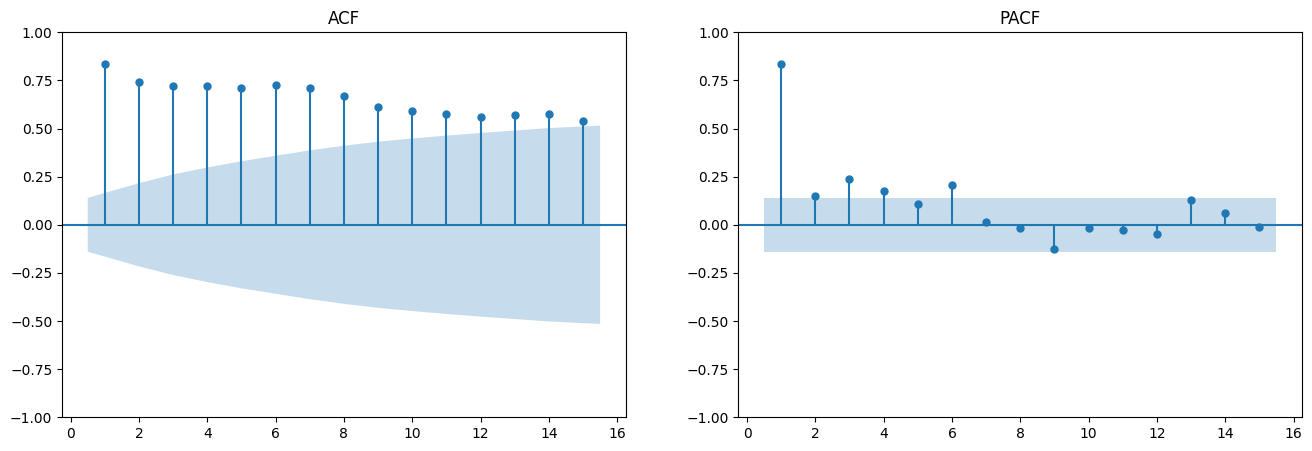

In [3]:
Y = df['weight_lbs']
sf.all_ac(Y)

In [4]:
sf.stationarity_test(Y)

('Non-Stationarity', 'Non-Stationarity')

                               SARIMAX Results                                
Dep. Variable:             weight_lbs   No. Observations:                  197
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -272.277
Date:                Wed, 04 Jun 2025   AIC                            554.555
Time:                        18:45:07   BIC                            570.946
Sample:                    11-19-2024   HQIC                           561.191
                         - 06-03-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
food          -0.2903      0.045     -6.449      0.000      -0.379      -0.202
exer          -0.0937      0.141     -0.662      0.508      -0.371       0.183
ma.L1         -0.4186      0.066     -6.389      0.0

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


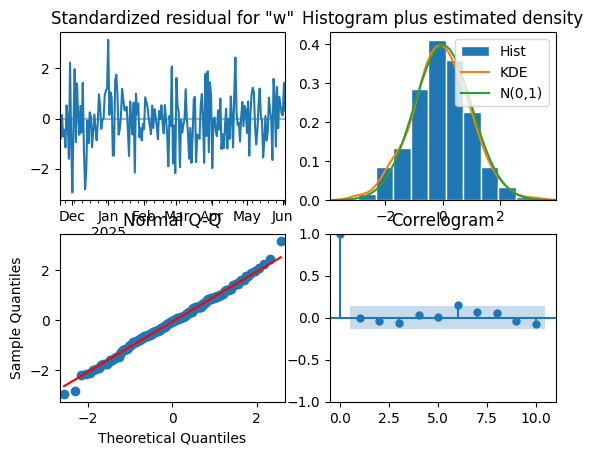

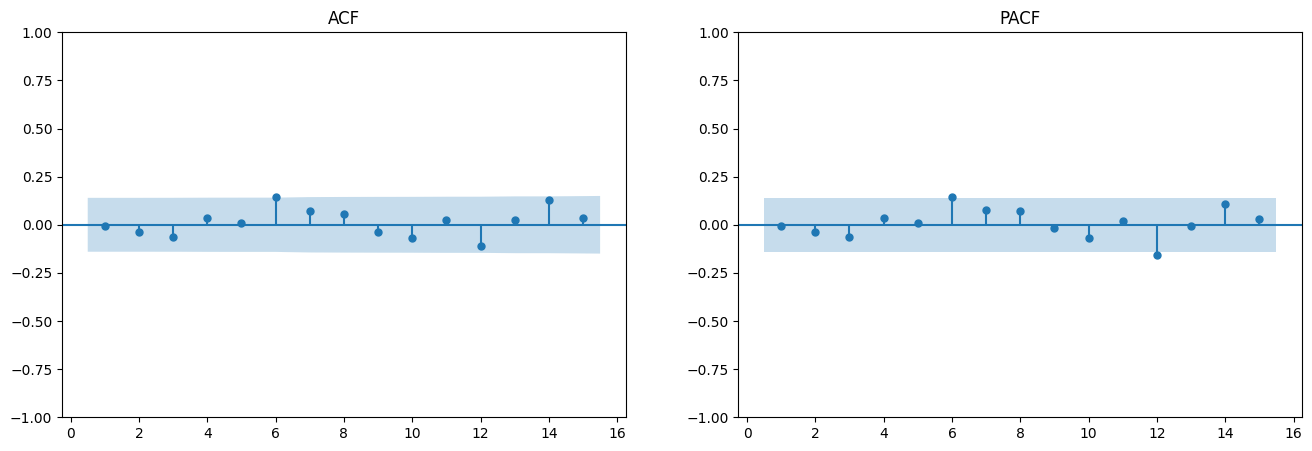

In [10]:
Y = df['weight_lbs']
x = df[['food', 'exer']]
model1 = SARIMAX(Y, order=(0,1,2), exog=x).fit(disp=False)
sf.diagnostic(model1)